In [1]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
os.chdir('..')

In [3]:
def get_sentences(data_list):
    sentences = []
    indices = data_list.index.unique()
    done = 0
    for i in indices:
        
        temp = data_list.ix[i]
        n_encodings = len(temp.encoding.unique())
        words = temp[['word','encoding','part_of_speech']].values
        if len(words) > 2 and n_encodings > 1:
            sentences.append(words)
        done += 1
        sys.stdout.write('Done with {} sentence from 22726.\r'.format(done));
        sys.stdout.flush()
    return sentences

In [4]:
data_list = pd.read_csv('../data/go/go_cc3.csv')
data_list.word.fillna('NA', inplace=True)

temp = pd.read_csv('../data/go/go_bp3.csv')
temp.word.fillna('NA', inplace=True)

temp1 = pd.read_csv('../data/go/go_mf3.csv')
temp1.word.fillna('NA', inplace=True)
temp1 = temp1.rename(columns={'encoding' : 'encoding_z'})

data_list = data_list.merge(temp, on=['article', 'sentence_no', 'word_no'])
data_list = data_list.merge(temp1, on=['article', 'sentence_no', 'word_no'])
data_list.sort_values(['article', 'sentence_no'], kind='mergesort', inplace=True)
x_counts = data_list.encoding_x.value_counts()
y_counts = data_list.encoding_y.value_counts()
z_counts = data_list.encoding_z.value_counts()
# data_list['encoding_x'] = data_list.encoding_x.apply(lambda x: x if x_counts[x] > 4 else 'O')
# data_list['encoding_y'] = data_list.encoding_y.apply(lambda x: x if y_counts[x] > 4 else 'O')
# data_list['encoding'] = [i if (i == 'O' and j == 'O') else j for i,j in zip(data_list.encoding_x, data_list.encoding_y)]
temp_encoding = []
for i,j,k in zip(data_list.encoding_x, data_list.encoding_y, data_list.encoding_z):
    if i == j and j == k:
        temp_encoding.append('O')
    elif i == 'O' and j != 'O':
        temp_encoding.append(j)
    elif j == 'O' and i != 'O':
        temp_encoding.append(i)
    else:
        temp_encoding.append(k)
data_list['encoding'] = temp_encoding
data_list.drop(['word_x', 'word_y', 'part_of_speech_x', 'part_of_speech_y',
                'encoding_x', 'encoding_y', 'encoding_z'], axis=1, inplace=True)
data_list.set_index(['article', 'sentence_no'], inplace=True)


val_cnt = data_list.encoding.value_counts()
# data_list['encoding'] = data_list.encoding.apply(lambda x: 'O' if val_cnt[x] < 10 else x)
# data_list = data_list.rename(columns={'word_x' : 'word'})

In [5]:
# r = 0
# while r < 5:
#     news = []
#     for _, w in data_list.iterrows():
#         enc = w['new_encoding']
#         if cnts[enc] < 5:
#             if enc[0] == 'I':
#                 enc = "I-" + enc[2:]
#             else:
#                 enc = "B-" + enc[2:]
            
#             vals = go[go.Child == enc[2:]].Parent.values
            
#             if len(vals) == 0 or not vals[0].startswith("GO:"):
#                 news.append(enc)
#                 continue
#             new_enc = enc[0:2] + vals[0]
#             news.append(new_enc)
#         else:
#             news.append(enc)
#     cnts = pd.Series(news).value_counts()
#     data_list['new_encoding'] = news
#     print(len(cnts[cnts < 5]))
#     r += 1

In [6]:
go = pd.read_csv('../data/go/GO_AllSubsumers.tsv', sep='\t', header=None)
go.columns = ['Child', 'Parent']
go.Child = go.Child.apply(lambda x: x.replace('_',':'))
go.Parent = go.Parent.apply(lambda x: x.replace('_',':'))
go_vc = go.Parent.value_counts()
go['ParentCount'] = go.Parent.apply(lambda x: go_vc[x])
go = go.sort_values('ParentCount', ascending=False)

mydict = dict()
for i in data_list.encoding.unique():
    if i != 'O':
        child = i[2:]
        vals = go[go.Child == child].Parent.values
        if(len(vals) != 0 and vals[0].startswith("GO:")): ## needs revision and explanation
            mydict[child] = vals[0]
        else:
            mydict[child] = child

k = 0
r = 0
while r < 1:
    news = [0] * len(data_list)
    for _, w in data_list.iterrows():
        enc = w['encoding']
        if enc != 'O':
            pre = enc[:2]
            enc = enc[2:]
            news[k] = pre + mydict[enc]
        else:
            news[k] = 'O'
        k += 1
    r += 1
        
data_list['encoding'] = news

In [7]:
data_list = get_sentences(data_list)
print('\n')
print(data_list[0])
print(len(data_list))

words = list(set(y[0] for x in data_list for y in x))
n_words = len(words)
print(n_words)

tags = list(set(y[1] for x in data_list for y in x))
n_tags = len(tags)
print(n_tags)

poss = list(set(y[2] for x in data_list for y in x))
n_poss = len(poss)
print(n_poss)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


Done with 22726 sentence from 22726.

[['Gender' 'O' 'NN']
 ['does' 'O' 'VBZ']
 ['not' 'O' 'RB']
 ['typically' 'O' 'RB']
 ['affect' 'O' 'JJ']
 ['IOP' 'O' 'NNP']
 ['and' 'O' 'CC']
 ['aging' 'B-GO:0032502' 'VBG']
 ['results' 'O' 'NNS']
 ['in' 'O' 'IN']
 ['an' 'O' 'DT']
 ['IOP' 'O' 'NNP']
 ['decrease' 'O' 'NN']
 ['in' 'O' 'IN']
 ['some' 'O' 'DT']
 ['strains' 'O' 'NNS']
 ['.' 'O' '.']]
7894
16446
805
44


In [8]:
max_len = 75
max_len_char = 15

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["O"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["O"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

pos2idx = {w: i+1 for i, w in enumerate(poss)}
pos2idx["X"] = 0
idx2pos = {i: w for w, i in pos2idx.items()}

In [9]:
print(tag2idx)

{'B-GO:0097458': 407, 'B-GO:0046649': 2, 'B-GO:0042698': 3, 'I-GO:0097435': 4, 'I-GO:0034248': 5, 'B-GO:0007017': 6, 'I-GO:0005924': 7, 'I-GO:0072595': 8, 'I-GO:0007548': 9, 'B-GO:0015718': 724, 'I-GO:0005819': 10, 'B-GO:0022616': 11, 'I-GO:0050663': 12, 'B-GO:0015833': 13, 'B-GO:0048729': 14, 'B-GO:0043703': 15, 'I-GO:0050896': 16, 'B-GO:0006261': 1, 'B-GO:0045892': 206, 'B-GO:0006310': 17, 'B-GO:1903046': 18, 'I-GO:0010954': 19, 'I-GO:0099024': 748, 'I-GO:0045835': 675, 'I-GO:0043256': 415, 'I-GO:0033500': 20, 'B-GO:0065003': 23, 'I-GO:0006417': 139, 'B-GO:0006790': 25, 'I-GO:0007276': 26, 'B-GO:0071485': 27, 'B-GO:0044454': 192, 'B-GO:0035556': 29, 'I-GO:0022412': 31, 'B-GO:0051169': 32, 'I-GO:0070161': 33, 'B-GO:0042044': 34, 'I-GO:0072376': 278, 'B-GO:0022411': 36, 'I-GO:0007389': 37, 'B-GO:0061982': 38, 'I-GO:0007423': 39, 'B-GO:0098791': 40, 'B-GO:0071705': 41, 'B-GO:0001659': 42, 'I-GO:1901565': 43, 'I-GO:0002526': 44, 'I-GO:0006351': 421, 'B-GO:0099024': 46, 'B-GO:0009048': 47

In [10]:
print(pos2idx)

{'JJS': 1, '#': 2, 'PRP$': 3, '$': 4, 'MD': 5, 'WP': 6, "''": 7, 'RP': 19, 'TO': 8, 'EX': 9, 'CC': 10, 'VBZ': 11, 'RBS': 12, 'POS': 13, '(': 14, 'X': 0, 'WDT': 15, ')': 17, 'FW': 37, 'VBP': 18, 'WP$': 21, 'NNS': 22, 'PDT': 23, 'VB': 24, 'VBG': 25, 'WRB': 26, 'SYM': 27, 'NNP': 28, 'PRP': 29, 'VBN': 30, '``': 31, ':': 35, 'JJ': 32, ',': 34, 'UH': 39, 'NNPS': 38, 'NN': 36, '.': 33, 'VBD': 40, 'RB': 41, 'DT': 16, 'IN': 42, 'RBR': 20, 'CD': 43, 'JJR': 44}


In [11]:
X_word = [[w[0] for w in s] for s in data_list]
new_X = []
for seq in X_word:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("ENDPAD")
    new_X.append(new_seq)
X_word = new_X

In [12]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

128


In [13]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["O"] = 0

In [14]:
X_char = []
for sentence in data_list:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("O"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))


In [15]:
from keras.preprocessing.sequence import pad_sequences
X_pos = [[pos2idx[w[2]] for w in s] for s in data_list]
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, value=pos2idx["X"], padding='post', truncating='post')

In [16]:
y = [[tag2idx[w[1]] for w in s] for s in data_list]
y = pad_sequences(maxlen=max_len, sequences=y,value=tag2idx["O"], padding='post', truncating='post')

In [17]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags+1) for i in y]

In [18]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.3, random_state=2018)
X_pos_tr, X_pos_te, _, _ = train_test_split(X_pos, y, test_size=0.3, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.3, random_state=2018)

In [19]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [20]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
sess = tf.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(32*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable module/aggregation/weights:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/weights
INFO:tensorflow:Initialize variable module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel
INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_4
INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_5
INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_

In [21]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D, Flatten
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D, Lambda

# input and embedding for words
word_in = Input(shape=(max_len,), dtype=tf.string)

emb_word = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(word_in)

# input and embedding for parts of speech
pos_in = Input(shape=(max_len,))
emb_pos = Embedding(input_dim=n_poss + 1, output_dim=len(pos2idx),
                     input_length=max_len, mask_zero=True)(pos_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=100,
                           input_length=max_len_char))(char_in)

dropout = Dropout(0.3)(emb_char)

# CNN
conv1d_out = TimeDistributed(Conv1D(kernel_size=3, filters=30, padding='same', activation='tanh', strides=1), name="Convolution")(dropout)
maxpool_out = TimeDistributed(MaxPooling1D(max_len_char), name="Maxpool")(conv1d_out)
char = TimeDistributed(Flatten(), name="Flatten")(maxpool_out)
char = Dropout(0.3)(char)

# main GRU
x = concatenate([emb_word, char, emb_pos])
main_gru = Bidirectional(GRU(units=200, return_sequences=True,
                             dropout=0.5,
                               recurrent_dropout=0.25))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_gru)

model = Model([word_in, pos_in, char_in], out)

In [22]:
from keras.optimizers import RMSprop
import keras.backend as K

def customLoss(yTrue,yPred):
    return - K.sum(yTrue * K.log(yPred))

rmsopt = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=rmsopt, loss=customLoss, metrics=['acc'])

In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 75, 15)       0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 75, 15, 100)  13000       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 75, 15, 100)  0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
Convolution (TimeDistributed)   (None, 75, 15, 30)   9030        dropout_1[0][0]                  
__________________________________________________________________________________________________
Maxpool (T

In [24]:
from keras.utils import plot_model
plot_model(model, to_file='../data/output/graphs/GRU-Elmo.png')

In [25]:
# CHANGE WEIGHTS MR SAAD
weights = {i:1 for i in range(0,n_tags+1)}
weights[0] = 1e-4
history = model.fit([X_word_tr[:len(X_word_tr)//32*32], X_pos_tr[:len(X_word_tr)//32*32],
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))[:len(X_word_tr)//32*32]],
                    np.array(y_tr[:len(X_word_tr)//32*32]),
                    batch_size=32, epochs=20, validation_data=([X_word_te[:len(y_te)//32*32], X_pos_te[:len(y_te)//32*32],
                     np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))[:len(y_te)//32*32]],
                    np.array(y_te[:len(y_te)//32*32])),
                    verbose=1)

Train on 5504 samples, validate on 2368 samples
Epoch 1/20
5504/5504 [==============================] - 102s 19ms/step - loss: 556.1791 - acc: 0.9368 - val_loss: 277.9600 - val_acc: 0.9572
Epoch 2/20
5504/5504 [==============================] - 101s 18ms/step - loss: 247.2746 - acc: 0.9594 - val_loss: 235.1493 - val_acc: 0.9655
Epoch 3/20
5504/5504 [==============================] - 103s 19ms/step - loss: 192.3840 - acc: 0.9667 - val_loss: 196.0490 - val_acc: 0.9695
Epoch 4/20
5504/5504 [==============================] - 102s 19ms/step - loss: 157.8522 - acc: 0.9714 - val_loss: 178.9740 - val_acc: 0.9726
Epoch 5/20
5504/5504 [==============================] - 104s 19ms/step - loss: 135.1816 - acc: 0.9749 - val_loss: 171.4182 - val_acc: 0.9744
Epoch 6/20
5504/5504 [==============================] - 103s 19ms/step - loss: 119.1145 - acc: 0.9774 - val_loss: 162.4569 - val_acc: 0.9762
Epoch 7/20
5504/5504 [==============================] - 104s 19ms/step - loss: 105.2036 - acc: 0.9797 - va

In [26]:
hist = pd.DataFrame(history.history)
hist.to_csv('../data/results/performance/GO_GRU-Elmo-Parent1.tsv', sep='\t')

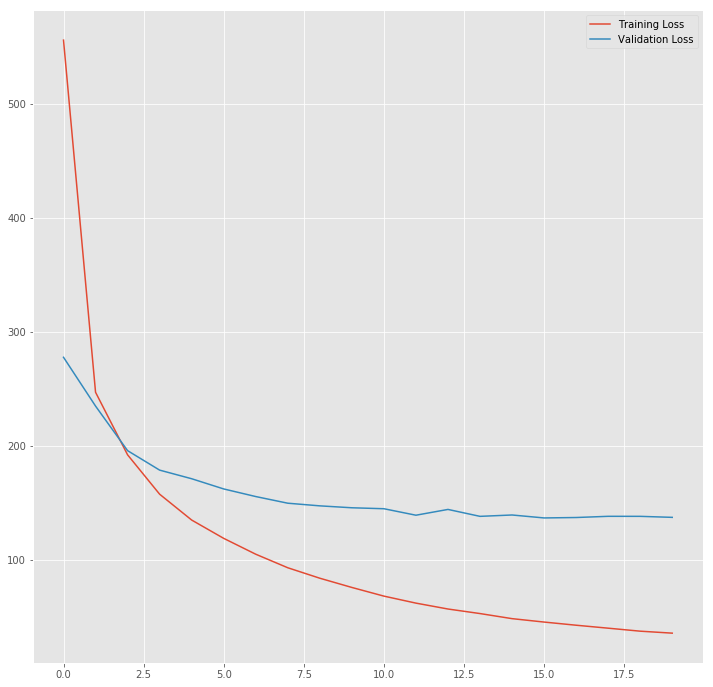

In [27]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()
plt.show()

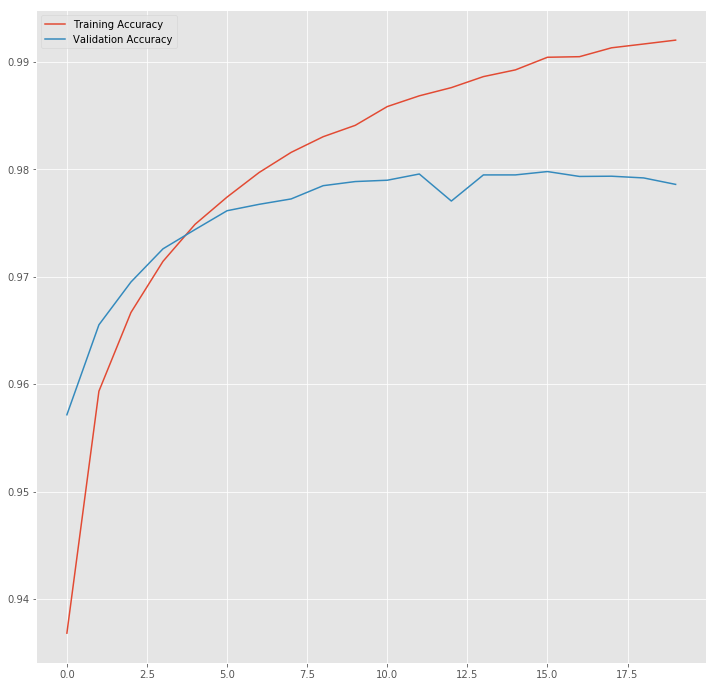

In [28]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"], label='Training Accuracy')
plt.plot(hist["val_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

In [29]:
from seqeval.metrics import classification_report

predicted = model.predict([X_word_te[:len(y_te)//32*32], X_pos_te[:len(y_te)//32*32],
                        np.array(X_char_te[:len(y_te)//32*32]).reshape((len(X_char_te[:len(y_te)//32*32]),
                                                     max_len, max_len_char))])
true = []
predicted_val = []
predicted_val2 = []
word = []
for i in range(len(predicted)):
    p_tmp = np.argmax(predicted[i], axis=-1)
    
    predicted_temp = predicted[i].copy()
    predicted_temp[:,0] = 0
    p2_tmp = np.argmax(predicted_temp, axis=-1)
    
    k = 0
    for p1,p2 in zip(p_tmp, p2_tmp):
        if p1 != p2:
            if predicted[i][k][p2] < 0.2:
                p2_tmp[k] = p1
        k+=1
    t_tmp = np.argmax(y_te[i], -1)
    word.append(X_word_te[i])
    predicted_val.append(p_tmp)
    predicted_val2.append(p2_tmp)
    true.append(t_tmp)

wd = [list(map(lambda x: y, y)) for y in word]    
p = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val]
p2 = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val2]
t = [list(map(lambda x: idx2tag[x], y)) for y in true]

report = classification_report(list(itertools.chain.from_iterable(t)), 
                                    list(itertools.chain.from_iterable(p)))
# print "\n"
print(report)

             precision    recall  f1-score   support

 GO:0090304       0.00      0.00      0.00         1
 GO:0048468       0.00      0.00      0.00         5
 GO:0070192       0.74      0.81      0.77        21
 GO:0044267       0.00      0.00      0.00         2
 GO:0008406       0.50      0.40      0.44         5
 GO:0001816       0.00      0.00      0.00         3
 GO:0032446       0.00      0.00      0.00         2
 GO:0002376       0.00      0.00      0.00         3
 GO:0006913       0.67      0.57      0.62         7
 GO:0009888       0.00      0.00      0.00         2
 GO:0005882       0.00      0.00      0.00         2
 GO:0042384       1.00      0.50      0.67         2
 GO:0048646       0.43      0.43      0.43         7
 GO:0001659       1.00      0.40      0.57         5
 GO:0003002       0.00      0.00      0.00         2
 GO:0098764       0.90      0.89      0.90        53
 GO:0051259       0.00      0.00      0.00         2
 GO:0050909       0.86      0.86      0.86   

In [30]:
i = 200
pred = np.argmax(predicted[i], axis=-1)
pred2 = np.argmax(predicted[i], axis=-1)
print(pred)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, tr, pred in zip(X_word_te[i], np.argmax(y_te[i], -1), pred):
    if w != 0:
        print("{:15}: {:5} {}".format(w, idx2tag[tr], idx2tag[pred]))
        
# pd = model.predict(np.array([X_te[i]]))
# pd = np.argmax(pd, axis=-1)
# true = np.argmax(y_te[i], -1)
# print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
# print(30 * "=")

# for w, t1, pred in zip(X_te[i], true, pd[0]):
#     if w != 0:
#         print("{:15}: {:5} {}".format(words[w-1], tags[t1], tags[pred]))

[  0   0   0   0   0   0 594   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
Word           ||True ||Pred
(              : O     O
A              : O     O
)              : O     O
ES             : O     O
cells          : O     O
were           : O     O
transfected    : B-GO:0009292 B-GO:0009292
with           : O     O
p150CAF-1      : O     O
or             : O     O
control        : O     O
siRNA          : O     O
vectors        : O     O
.              : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O    

In [31]:
def print_report_with_unique_vals(report):
    reportlines = report.split('\n')
    print(reportlines[0]+ '\t  uniques\n')
    for i in reportlines[2:-3]:
        tag = i.split()[0]
        unique_vals = len(pd.Series([w[0] for s in data_list for w in s if w[1] == tag]).unique())
        print(i + '\t\t' + str(unique_vals))
    print('\n' + reportlines[-2] + '\n')

In [32]:
import pandas as pd

df = pd.DataFrame(
{
    'Predicted' : list(itertools.chain.from_iterable(p)),
    'Predicted2' : list(itertools.chain.from_iterable(p2)),
    'Ground Truth': list(itertools.chain.from_iterable(t)),
    'Word' : list(itertools.chain.from_iterable(wd)),
}
)


In [33]:
df = df[df['Word'] != 'O']

In [40]:
df1 = df[(df['Predicted'] != 'O') & (df['Ground Truth'] != 'O') | 
         (df['Predicted'] == 'O') & (df['Ground Truth'] != 'O') |
         (df['Predicted'] != 'O') & (df['Ground Truth'] == 'O')
        ]

report = classification_report(df1['Ground Truth'], 
                                    df1['Predicted'])
print("\n")
print_report_with_unique_vals(report)



             precision    recall  f1-score   support	  uniques

GO:0000792O       0.80      0.80      0.80         5		0
GO:0016265O       0.96      0.98      0.97        50		0
GO:0032147O       0.00      0.00      0.00         2		0
GO:0044459O       0.00      0.00      0.00         3		0
GO:0007611O       0.95      0.92      0.93        60		0
GO:0034622O       1.00      1.00      1.00         3		0
GO:0043043O       0.67      0.91      0.77        11		0
GO:0098916O       0.00      0.00      0.00         1		0
GO:0001667O       0.00      0.00      0.00         1		0
GO:0061024O       1.00      0.60      0.75         5		0
GO:0005720O       0.82      1.00      0.90        14		0
GO:0030424O       0.00      0.00      0.00         1		0
GO:0000803O       0.78      0.80      0.79        45		0
GO:0043256O       0.00      0.00      0.00         1		0
GO:0009152O       0.00      0.00      0.00         1		0
GO:0030099O       0.50      0.50      0.50         2		0
GO:0007599O       0.69      0.92      

GO:0009605O       1.00      1.00      1.00         1		0
GO:0007067O       1.00      1.00      1.00         9		0
GO:0072330O       0.00      0.00      0.00         1		0
GO:0010604O       0.00      0.00      0.00         6		0
GO:0001816O       0.00      0.00      0.00         3		0
GO:0050877O       1.00      0.25      0.40         4		0
GO:0051649O       0.00      0.00      0.00         1		0
GO:0044424O       0.87      0.87      0.87        30		0
GO:0022607O       0.45      0.56      0.50        16		0
GO:0042116O       0.00      0.00      0.00         1		0
GO:0007281O       0.00      0.00      0.00         2		0
GO:0022616O       0.00      0.00      0.00         1		0
GO:0044257O       0.00      0.00      0.00         1		0
GO:0019320O       0.00      0.00      0.00         2		0
GO:0032196O       0.00      0.00      0.00         1		0
GO:0048232O       1.00      0.67      0.80         6		0
GO:0043231O       0.84      0.94      0.89       144		0
GO:0051301O       1.00      0.40      0.57      

GO:0070192O       0.73      0.76      0.74        21		0
GO:0009653O       0.56      0.82      0.67        11		0
GO:0006396O       0.88      0.92      0.90        25		0
GO:0015850O       0.00      0.00      0.00         1		0
GO:0099086O       0.60      1.00      0.75         3		0
GO:0043679O       1.00      0.67      0.80         3		0
GO:0044085O       0.00      0.00      0.00         1		0
GO:0043227O       0.68      1.00      0.81        13		0
GO:0140013O       0.00      0.00      0.00         2		0

avg / total       0.77      0.82      0.78      3893



In [36]:
df1[df1['Ground Truth'] == 'GO:0098794']

,Ground Truth,Predicted,Predicted2,Word


In [37]:
df2 = df[(df['Predicted2'] != 'O') & (df['Ground Truth'] != 'O') | 
         (df['Predicted2'] == 'O') & (df['Ground Truth'] != 'O') |
         (df['Predicted2'] != 'O') & (df['Ground Truth'] == 'O')
        ]

report = classification_report(df2['Ground Truth'], 
                                    df2['Predicted2'])
print("\n")
print_report_with_unique_vals(report)



             precision    recall  f1-score   support	  uniques

GO:0000792O       0.80      0.80      0.80         5		0
GO:0016265O       0.96      1.00      0.98        50		0
GO:0032147O       0.00      0.00      0.00         2		0
GO:0044459O       0.00      0.00      0.00         3		0
GO:0044728O       0.75      1.00      0.86         3		0
GO:0007611O       0.95      0.92      0.93        60		0
GO:0034622O       1.00      1.00      1.00         3		0
GO:0043043O       0.67      0.91      0.77        11		0
GO:0098916O       0.00      0.00      0.00         1		0
GO:0033500O       0.00      0.00      0.00         2		0
GO:0061024O       1.00      0.60      0.75         5		0
GO:0005720O       0.68      0.93      0.79        14		0
GO:0030424O       0.00      0.00      0.00         1		0
GO:0000803O       0.77      0.82      0.80        45		0
GO:0043256O       0.00      0.00      0.00         1		0
GO:0030099O       0.50      0.50      0.50         2		0
GO:0006357O       0.54      0.95      

GO:0050877O       1.00      0.50      0.67         4		0
GO:0051649O       0.00      0.00      0.00         1		0
GO:0044424O       0.87      0.87      0.87        30		0
GO:0022607O       0.39      0.56      0.46        16		0
GO:0042116O       0.00      0.00      0.00         1		0
GO:0007281O       0.00      0.00      0.00         2		0
GO:0022616O       0.00      0.00      0.00         1		0
GO:0044257O       0.00      0.00      0.00         1		0
GO:0019320O       0.00      0.00      0.00         2		0
GO:0032196O       0.00      0.00      0.00         1		0
GO:0048232O       1.00      0.67      0.80         6		0
GO:0043231O       0.79      0.94      0.86       144		0
GO:0007017O       0.00      0.00      0.00         1		0
GO:0044057O       0.00      0.00      0.00         1		0
GO:0044428O       0.67      0.67      0.67        15		0
GO:0006810O       0.69      0.75      0.72        12		0
GO:0048666O       0.50      0.60      0.55         5		0
GO:0055067O       0.00      0.00      0.00      

GO:0008406O       0.50      0.40      0.44         5		0
GO:0015833O       0.00      0.00      0.00         4		0
GO:0007267O       0.00      0.00      0.00         2		0
GO:0008305O       0.00      0.00      0.00         2		0
GO:0009653O       0.50      0.82      0.62        11		0
GO:0006396O       0.88      0.92      0.90        25		0
GO:0042698O       0.00      0.00      0.00         1		0
GO:0016477O       0.50      1.00      0.67         1		0
GO:0099086O       0.60      1.00      0.75         3		0
GO:0043679O       1.00      0.67      0.80         3		0
GO:0044085O       0.00      0.00      0.00         1		0
GO:0043227O       0.68      1.00      0.81        13		0
GO:0009152O       0.00      0.00      0.00         1		0

avg / total       0.75      0.83      0.78      3894



In [38]:
df.to_csv('../data/results/GO_merged_Elmo.tsv', sep='\t')

In [39]:
!python2.7 ComputeSim.py ../data/results/GO_merged_Elmo.tsv ../data/go/GO_AllSubsumers.tsv

('Mean semantic similarity: ', 0.845)
